# Team Name: Resume Classifier
Team: Allen Snyder, Kevin Schroeder, Si Liang

Created on: 10/30/2025

# Preprocessing steps 30pts

Provide all essential steps that you deem necessary for your application

In [17]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Resume Data

In [17]:
# from google.colab import files

import re
import gc
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.stats import loguniform


In [18]:
# Load the CSV file (update the path)
df = pd.read_csv('./Resume.csv')

df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


## Raw Text of Resume #1 and #2

In [19]:
display(df['Resume_str'][0][:300])

'         HR ADMINISTRATOR/MARKETING ASSOCIATE\n\nHR ADMINISTRATOR       Summary     Dedicated Customer Service Manager with 15+ years of experience in Hospitality and Customer Service Management.   Respected builder and leader of customer-focused teams; strives to instill a shared, enthusiastic commit'

In [20]:
display(df['Resume_str'][1][:300])

'         HR SPECIALIST, US HR OPERATIONS       Summary     Versatile  media professional with background in Communications, Marketing, Human Resources and Technology.\xa0        Experience     09/2015   to   Current     HR Specialist, US HR Operations    Company Name   －   City  ,   State       Managed'

## Create Corpus

In [21]:
corpus = df['Resume_str'].tolist()

## Normalize Corpus

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = list(stopwords.words('english'))

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    wpt = nltk.WordPunctTokenizer()
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)
len(norm_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/USCHRKE/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2484

### Preprocess corpus and print an example of a preprocess sentence

In [23]:
print(norm_corpus[0][:300])

hr administratormarketing associate hr administrator summary dedicated customer service manager 15 years experience hospitality customer service management respected builder leader customerfocused teams strives instill shared enthusiastic commitment customer service highlights focused customer satis


In [24]:
print(norm_corpus[1][:300])

hr specialist us hr operations summary versatile media professional background communications marketing human resources technology experience 092015 current hr specialist us hr operations company name city state managed communication regarding launch operations group policy changes system outages de


# Feature extraction (30pts)

Implement any existing feature extraction tools and methods (term frequency, word embeddings etc)

In [25]:
X = norm_corpus
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', LogisticRegression(class_weight='balanced', max_iter=2000))
    ]),
    'MultinomialNB': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', MultinomialNB())
    ]),
    'LinearSVC': Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stop_words, max_features=10000)),
        ('classifier', LinearSVC(class_weight='balanced', max_iter=2000))
    ])
}

full_param_grids = {
    'LogisticRegression': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # LR parameters
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'saga']
    },
    'MultinomialNB': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # Naive Bayes parameters
        'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
        'classifier__fit_prior': [True, False]
    },
    'LinearSVC': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # LinearSVC parameters
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__loss': ['hinge', 'squared_hinge']
    }
}

param_grids = {
    'LogisticRegression': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # LR parameters
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'saga']
    },
    'MultinomialNB': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # Naive Bayes parameters
        'classifier__alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
        'classifier__fit_prior': [True, False]
    },
    'LinearSVC': {
        # TF-IDF parameters
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [3, 5, 10],
        'tfidf__max_df': [0.7, 0.8, 0.9],
        'tfidf__max_features': [None, 5000, 10000],

        # LinearSVC parameters
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__loss': ['hinge', 'squared_hinge']
    }
}


# Train and tune all models
grid_results = {}

for model_name in pipelines.keys():
    print(f"\n{'='*80}")
    print(f"Tuning {model_name}...")
    print(f"{'='*80}")

    random_search = RandomizedSearchCV(
        pipelines[model_name],
        param_grids[model_name],
        # n_iter=20,
        n_iter=50,
        cv=5,
        scoring='f1_weighted',
        n_jobs=2,
        verbose=2,
        random_state=42,
        return_train_score=False
    )

    # Fit on training data only (not the entire dataset)
    random_search.fit(X_train, y_train)

    # Store results
    grid_results[model_name] = {
        'best_estimator': random_search.best_estimator_,
        'best_params': random_search.best_params_,
        'best_cv_score': random_search.best_score_,
        'cv_results': random_search.cv_results_
    }

    print(f"\nBest parameters for {model_name}:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

    # Clear memory between models
    del random_search
    # gc.collect()


Tuning LogisticRegression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.7, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.7, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.7, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.7, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga, tfidf__max_df=0.7, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); to

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=lbfgs, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   5.7s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=lbfgs, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solve

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.1s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.2s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.2s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.1s
[CV] END classifier__C=0.1, classifier

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 2); total time=   2.8s
[CV] END classifier__C=100, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.8s
[CV] END classifier__C=100, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   2.6s
[CV] END classifier__C=100, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.0s
[CV] END classifier__C=100, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] E

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   1.5s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   1.9s
[CV] END classifier__C=0.01, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.5s
[CV] END classifier__C=0.01, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.5s
[CV] END classifier__C=0.01, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.5s
[CV] END classifier__C=0.01, classifier__loss=squared_hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   1.5s
[CV]

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.1s
[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   2.5s
[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.0s
[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.0s
[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.2s
[CV] END classifier__C=1, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.4s
[CV] END classifier__C=0.01, classifier__loss=hinge,

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   1.7s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=5000, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.9s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   3.8s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.3s


/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.6s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.3s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.9s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.7s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.9s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   5.0s
[CV] END classifier__C=100, classifi

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.8s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.0s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.5s


/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.0s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.2s
[CV] END classifier__C=0.01, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.4s
[CV] END classifier__C=0.01, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.3s
[CV] END classifier__C=0.01, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.3s
[CV] END classifier__C=0.01, classifier__loss=hinge, tfidf__max_df=0.7, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 3); total time=   4.5s
[CV] END classifier__C=0.01, cla

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.5s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.7s
[CV] END classifier__C=0.1, classifier__loss=squared_hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 1); total time=   0.8s
[CV] END classifier__C=0.1, classifier__loss=squared_hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 1); total time=   0.7s
[CV] END classifier__C=0.1, classifier__loss=squared_hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 1); total time=   0.8s
[CV] END classifier__C=0.1, classifier__loss=squared_hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=10, tfidf__ngram_range=(1, 1); total time=   0.9s
[C

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 3); total time=   5.4s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   1.3s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   1.3s


/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=5000, tfidf__min_df=10, tfidf__ngram_range=(1, 3); total time=   5.1s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   1.5s


/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   1.8s
[CV] END classifier__C=100, classifier__loss=hinge, tfidf__max_df=0.8, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   1.6s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.7s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   4.9s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.5s
[CV] END classifier__C=10, classifier__loss=hinge, tfidf__max_df=0.9, tfidf__max_features=None, tfidf__min_df=3, tfidf__ngram_range=(1, 3); total time=   5.2s
[CV] END classifier__C=10, classifier__los

# Main functionality (30pts)

This is your main task. For example, if you are creating a translation app, your main task is Translation.

## Description:

This project will be building a resume classifier for job fit prediction. This application will help to automate the resume screening process for job applicants by scanning the incoming resumes and identifying if these applicants would be a good fit for the position. This will be a system that analyzes resumes and will automatically categorize them into job domains such as Data Science, Marketing, Software Engineering, and so on based on extracted skills, experience, and education. This project will utilize several of the techniques covered so far throughout this course, including tokenization, vectorization, classification models like MultinomialNB and Logistic Regression, hyper-parameter tuning, and evaluation metrics.

## Model Evaluation

In [ ]:
print(f"\n{'='*80}")
print("TEST SET EVALUATION")
print(f"{'='*80}")

comparison_results = []

for model_name, result in grid_results.items():
    print(f"\n{model_name} Results:")
    print("-" * 80)

    best_model = result['best_estimator']

    # Predictions
    y_pred = best_model.predict(X_test)

    # Metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted')

    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")

    comparison_results.append({
        'Model': model_name,
        'CV F1 Score': result['best_cv_score'],
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1
    })



TEST SET EVALUATION

LogisticRegression Results:
--------------------------------------------------------------------------------
                        precision    recall  f1-score   support

            ACCOUNTANT       0.82      0.93      0.87        29
              ADVOCATE       0.56      0.77      0.65        30
           AGRICULTURE       0.20      0.12      0.15         8
               APPAREL       0.55      0.55      0.55        20
                  ARTS       0.29      0.33      0.31        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.83      0.90      0.86        21
               BANKING       0.76      0.70      0.73        23
                   BPO       0.33      0.50      0.40         2
  BUSINESS-DEVELOPMENT       0.95      0.74      0.83        27
                  CHEF       0.89      0.71      0.79        24
          CONSTRUCTION       0.90      0.79      0.84        34
            CONSULTANT       0.50   

/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/inf2_training_py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

                        precision    recall  f1-score   support

            ACCOUNTANT       0.76      0.90      0.83        29
              ADVOCATE       0.53      0.57      0.55        30
           AGRICULTURE       0.14      0.12      0.13         8
               APPAREL       0.50      0.35      0.41        20
                  ARTS       0.00      0.00      0.00        18
            AUTOMOBILE       0.67      0.33      0.44         6
              AVIATION       0.58      0.86      0.69        21
               BANKING       0.76      0.70      0.73        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.69      0.67      0.68        27
                  CHEF       0.94      0.62      0.75        24
          CONSTRUCTION       0.85      0.68      0.75        34
            CONSULTANT       0.18      0.10      0.13        20
              DESIGNER       0.72      0.68      0.70        19
         DIGITAL-MEDIA       0.65      

## Compare All Models


MODEL COMPARISON
             Model  CV F1 Score  Test Accuracy  Test F1 Score
         LinearSVC     0.701357       0.710262       0.704508
LogisticRegression     0.694651       0.696177       0.694469
     MultinomialNB     0.563811       0.579477       0.567435


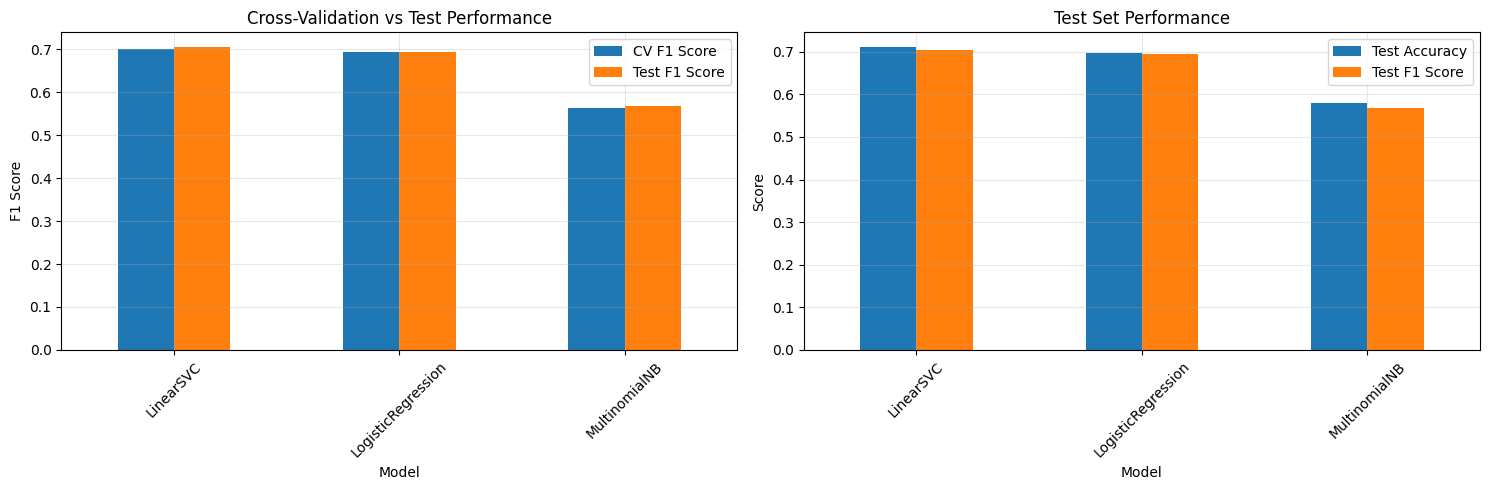

In [31]:
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Test F1 Score', ascending=False)

print(f"\n{'='*80}")
print("MODEL COMPARISON")
print(f"{'='*80}")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# CV vs Test scores
comparison_df.set_index('Model')[['CV F1 Score', 'Test F1 Score']].plot(
    kind='bar', ax=axes[0], rot=45
)
axes[0].set_title('Cross-Validation vs Test Performance')
axes[0].set_ylabel('F1 Score')
axes[0].legend(['CV F1 Score', 'Test F1 Score'])
axes[0].grid(True, alpha=0.3)

# Test metrics
comparison_df.set_index('Model')[['Test Accuracy', 'Test F1 Score']].plot(
    kind='bar', ax=axes[1], rot=45
)
axes[1].set_title('Test Set Performance')
axes[1].set_ylabel('Score')
axes[1].legend(['Test Accuracy', 'Test F1 Score'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

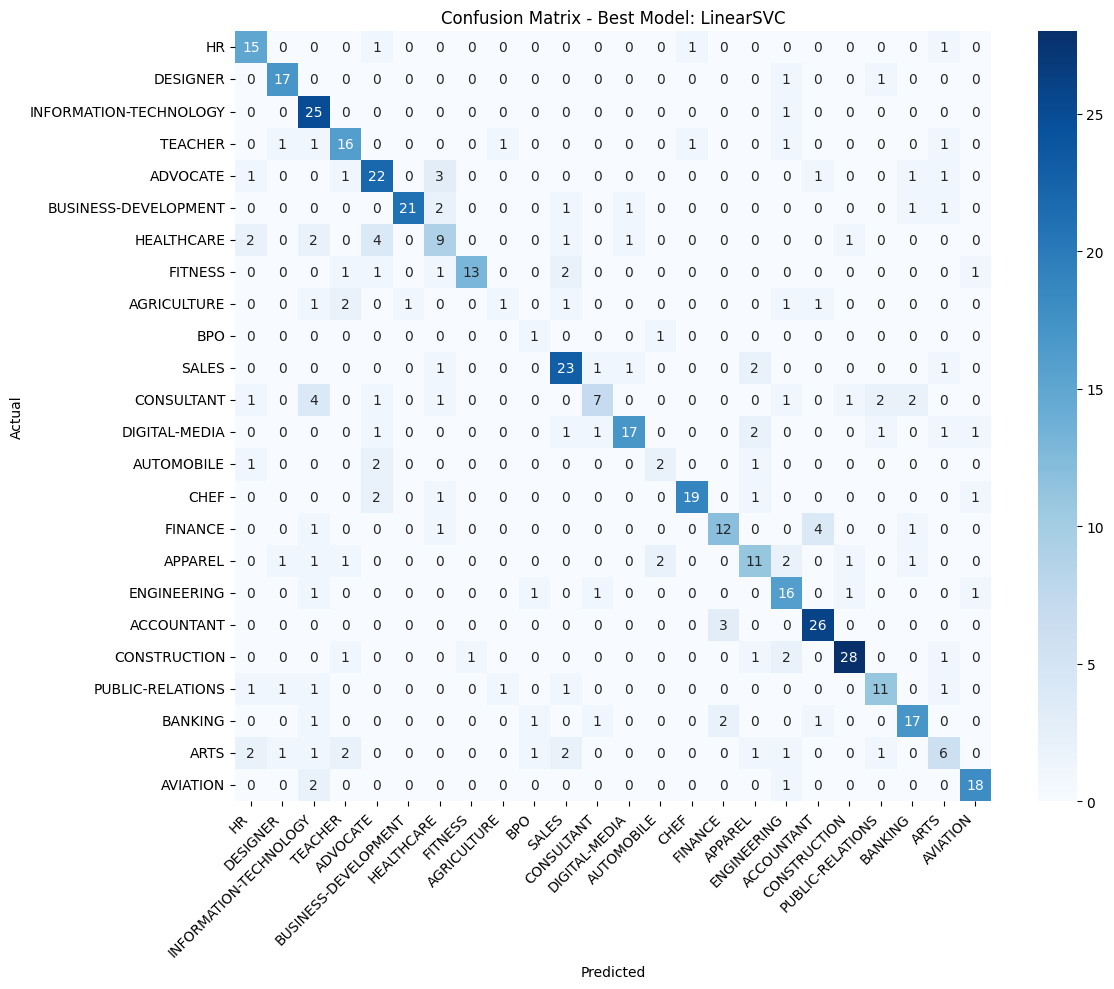

In [32]:
best_model_name = comparison_df.iloc[0]['Model']
best_model = grid_results[best_model_name]['best_estimator']

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=y.unique())

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(),
            yticklabels=y.unique(), cmap='Blues')
plt.title(f"Confusion Matrix - Best Model: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Personal Contribution Statement (10pts). Write it in markdown (do not use code block comments)

Summary of tasks and team members' contributions

Proofreading

Allen:


Kevin:


Si:


## --TESTING--

In [ ]:
#print([doc for doc in norm_corpus if len(doc.strip()) == 0])
#print(stop_words)

# Show the first few normalized resumes
#for i, doc in enumerate(norm_corpus[:5]):
#    print(f"Resume {i} after stop word removal:\n{doc}\n{'-'*50}")

import numpy as np
zero_vectors = np.sum(tfidf_matrix, axis=1) == 0
print(f"Number of resumes with all-zero TF-IDF vectors: {np.sum(zero_vectors)}")

# Print Top TF-IDF terms
feature_names = tfidf.get_feature_names_out()
resume_index = 0  # or any index
top_n = 10
sorted_indices = np.argsort(tfidf_matrix[resume_index])[::-1][:top_n]
top_terms = [(feature_names[i], tfidf_matrix[resume_index][i]) for i in sorted_indices]
print(f"Top {top_n} terms in Resume {resume_index}:\n", top_terms)


# Unsupervised Clustering
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

# Apply KMeans clustering
num_clusters = 6  # Adjust based on your job domains
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
labels = kmeans.labels_

# Assign cluster labels
df['Cluster'] = labels

# Extract top terms per cluster
feature_names = tfidf.get_feature_names_out()
clusters_top_terms = {}
for i in range(num_clusters):
    center = kmeans.cluster_centers_[i]
    top_indices = center.argsort()[::-1][:10]
    top_terms = [feature_names[ind] for ind in top_indices]
    clusters_top_terms[f"Cluster {i}"] = top_terms

print("Top terms per cluster:")
for cluster, terms in clusters_top_terms.items():
    print(f"{cluster}: {terms}")

# # Plot cluster distribution
# cluster_counts = Counter(labels)
# plt.figure(figsize=(8, 5))
# plt.bar(cluster_counts.keys(), cluster_counts.values(), color='skyblue')
# plt.xlabel('Cluster')
# plt.ylabel('Number of Resumes')
# plt.title('Resume Count per Cluster')
# plt.show()

# # Generate word clouds for each cluster
# for i in range(num_clusters):
#     cluster_docs = df[df['Cluster'] == i]['Resume_str'].dropna()
#     text = ' '.join(cluster_docs)
#     if text.strip():  # Only generate word cloud if text is not empty
#         wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')
#         plt.title(f'Cluster {i} Word Cloud')
#         plt.show()
#     else:
#         print(f"Cluster {i} has no valid text for word cloud.")


Number of resumes with all-zero TF-IDF vectors: 1
Top 10 terms in Resume 0:
 [('marketing', np.float64(0.1691223135867208)), ('dec', np.float64(0.14455838910414714)), ('medical', np.float64(0.14357612958661253)), ('relations', np.float64(0.133661647102418)), ('customer', np.float64(0.13106847650950035)), ('medical billing', np.float64(0.12069077340191318)), ('customer service', np.float64(0.11681777492080585)), ('billing', np.float64(0.11112865299939173)), ('terminology', np.float64(0.10243244107279766)), ('employee', np.float64(0.1016335770999694))]


## Save Model for Production Deployment

In [33]:
# Save the best model and preprocessing function for deployment
joblib.dump(best_model, 'best_resume_classifier_model.pkl')
print(f"Best model ({best_model_name}) saved to 'best_resume_classifier_model.pkl'")

# Save the normalize_document function and stop_words for use in the Streamlit app
import pickle
with open('preprocessing_utils.pkl', 'wb') as f:
    pickle.dump({'normalize_document': normalize_document, 'stop_words': stop_words}, f)
print("Preprocessing utilities saved to 'preprocessing_utils.pkl'")

Best model (LinearSVC) saved to 'best_resume_classifier_model.pkl'
Preprocessing utilities saved to 'preprocessing_utils.pkl'


## Launch Streamlit App

Run the cell below to launch the Streamlit web application for resume classification.

In [1]:
# Launch Streamlit app
# Note: This will open in a new browser window at http://localhost:8501
# To stop the server, use Kernel -> Interrupt or press the stop button

import subprocess
import webbrowser
import time
from threading import Timer

def open_browser():
    webbrowser.open('http://localhost:8501')

# Open browser after 2 seconds
Timer(2, open_browser).start()

# Run streamlit (this will block until you stop it)
!streamlit run app.py --server.headless=true


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.1.108:8501
  External URL: http://99.28.249.98:8501

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homeb